In [1]:
import numpy as  np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import cdist 
from scipy.special import kv, gamma

from sklearn.metrics import root_mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
def kriging(x, X, Y, sigma, cov):
    '''
    x : prediction point
    X : the vector of observation points
    Y : observations
    sigma : covariance matrix of observations
    cov : covariance function cov(h) 
    '''
    return cov(cdist(x, X)) @ np.linalg.solve(sigma, Y)

def var_kriging(x, X, sigma, cov):
    k_x_X = np.nan_to_num(cov(cdist(x, X)), nan=1)
    return 1 - np.diag(k_x_X @ np.linalg.solve(sigma, k_x_X.T))

In [3]:
def cov_matrix(cov_model, X_1, X_2, rho=1):
    return rho * np.nan_to_num(cov_model(cdist(X_1,X_2)), nan=1)

def k(X_1, X_2, cov_1, cov_2, cov_12, rho_12):
    return np.block([[cov_matrix(cov_1, X_1, X_2), cov_matrix(cov_12, X_1, X_2, rho_12)], 
                     [cov_matrix(cov_12, X_1, X_2, rho_12), cov_matrix(cov_2, X_1, X_2)]])    

In [4]:
def scatterplot(X,Y,title='',xlabel='',ylabel='',figsize=(7,6)):
    plt.scatter(X,Y)
    plt.plot([min(min(X), min(Y)), max(max(X), max(Y))], [min(min(X), min(Y)), max(max(X), max(Y))], ls = '--', lw = 2, c = 'r')
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)

In [5]:
def co_kriging(x, X, Y, cov_1, cov_2, cov_12, rho_12, sigma):
    'si x es un conjunto de puntos, entrega las predicciones (Y_1.T, Y_2.T).T'
    c = k(x, X, cov_1, cov_2, cov_12, rho_12)
    return c @ np.linalg.solve(sigma, Y)

In [6]:
def nestedCoKriging(x, X, Y_1, Y_2, A, cov_1, cov_2, cov_12, rho_12):
    '''
    x : prediction point
    X : the vector of all observation points
    Y_1 : all observations of random field Y_1
    Y_2 : all observations of random field Y_2
    A : list of list with submodels indexes
    cov_ij : covariance function between Y_i and Y_j
    '''
    M = np.zeros((2 * len(A), 1))
    k_M = np.zeros((2 * len(A), 2))
    K_M = np.zeros((2 * len(A), 2 * len(A)))

    for i in range(len(A)):
        k_x_X_i = k(x, X[A[i]], cov_1, cov_2, cov_12, rho_12)
        k_X_X_i = k(X[A[i]], X[A[i]], cov_1, cov_2, cov_12, rho_12)
        
        M[2*i:(2*i+2), :] = (k_x_X_i @ np.linalg.solve(k_X_X_i, np.concatenate([Y_1[A[i]], Y_2[A[i]]]))).reshape((2,1))
        k_M[2*i:(2*i+2), :] = k_x_X_i @ np.linalg.solve(k_X_X_i, k_x_X_i.T)
        K_M[2*i:(2*i+2),2*i:(2*i+2)] = k_M[2*i:(2*i+2), :]
        for j in range(i+1, len(A)):
            k_x_X_j = k(x, X[A[j]], cov_1, cov_2, cov_12, rho_12)
            k_X_X_j = k(X[A[j]], X[A[j]], cov_1, cov_2, cov_12, rho_12)
            k_X_i_X_j = k(X[A[i]], X[A[j]], cov_1, cov_2, cov_12, rho_12)
            
            K_M[2*i:(2*i+2),2*j:(2*j+2)] = np.linalg.solve(k_X_X_i, k_x_X_i.T).T @ k_X_i_X_j @ np.linalg.solve(k_X_X_j, k_x_X_j.T)  
            K_M[2*j:(2*j+2),2*i:(2*i+2)] = K_M[2*i:(2*i+2),2*j:(2*j+2)].T

    return k_M.T @ np.linalg.solve(K_M, M)

Matérn con $K_\nu$

In [7]:
matern_model = lambda t, nu: np.vectorize(lambda x: 2**(1-nu) / gamma(nu) * (t*x)**nu * kv(nu, t*x))

Parameters

In [8]:
d = 1
# n = m = 5

nu_1 = 12
theta_1 = 12.5

nu_2 = 5
theta_2 = 18

nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = -(theta_12**2/(theta_1*theta_2))**(d/2) * ( gamma(nu_1+d/2)*gamma(nu_2+d/2) / (gamma(nu_1)*gamma(nu_2)) )**(1/2) * gamma(nu_12)/gamma(nu_12+d/2)
rho_12

-0.7931385942329555

Example $d=1$

$f_1(x) = \sin(2\pi x) + x$

$f_2(x) = \cos(2\pi x+\pi/2) - x$

In [9]:
X = np.array([[0.1],[0.3],[0.5],[0.7],[0.9]])

f_1 = lambda x : np.sin(2 * np.pi * x) + x
f_2 = lambda x : np.cos(2 * np.pi * x + np.pi/2) - x

Y_1 = f_1(X)
Y_2 = f_2(X)

Covariance matrices

In [10]:
sigma_1 = cov_matrix(matern_model(theta_1, nu_1), X, X, rho=1)
sigma_2 = cov_matrix(matern_model(theta_2, nu_2), X, X, rho=1)
sigma_12 = cov_matrix(matern_model(theta_12, nu_12), X, X, rho=rho_12)

In [11]:
X_aux = np.linspace(-0.5,1.5,500).reshape((500,1))
Y_aux_1 = f_1(X_aux)
Y_aux_2 = f_2(X_aux)

In [12]:
A = [[0,1,2], [3,4]]

In [13]:
np.corrcoef(Y_1.reshape(-1), Y_2.reshape(-1))[0,1]

-0.9999999999999998

In [14]:
sigma = np.block([[sigma_1, sigma_12],
                  [sigma_12.T, sigma_2]])

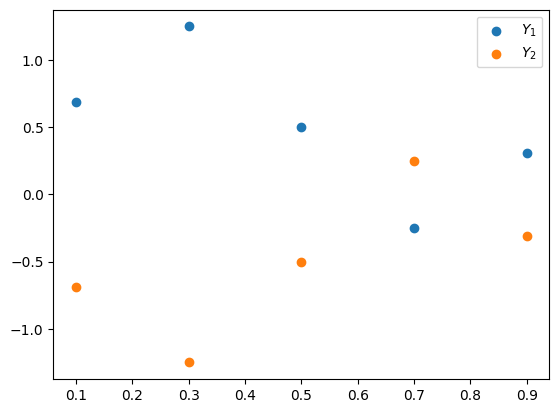

In [15]:
plt.scatter(X, Y_1, label = r'$Y_1$')
plt.scatter(X, Y_2, label = r'$Y_2$')
plt.legend();

Kriging con bandas de confianza del 95%

In [16]:
Y_1_K = kriging(X_aux, X[A[0]], Y_1[A[0]], sigma_1[A[0]][:,A[0]], matern_model(theta_1, nu_1))

In [17]:
var_1 = var_kriging(X_aux, X[A[0]], sigma_1[A[0]][:,A[0]], matern_model(theta_1, nu_1))

In [18]:
def plot_(X, Y, variance, n):
    plt.plot(X, Y.flatten(), c='b')
    plt.plot(X, Y.flatten() - 1.96 * np.sqrt(variance) / n, ls='--', c='b', lw=1)
    plt.plot(X, Y.flatten() + 1.96 * np.sqrt(variance) / n, ls='--', c='b', lw=1)

    plt.fill_between(X.flatten(),
                     Y.flatten() - 1.96 * np.sqrt(variance) / n, 
                     Y.flatten() + 1.96 * np.sqrt(variance) / n, 
                     color='blue', alpha=0.1)

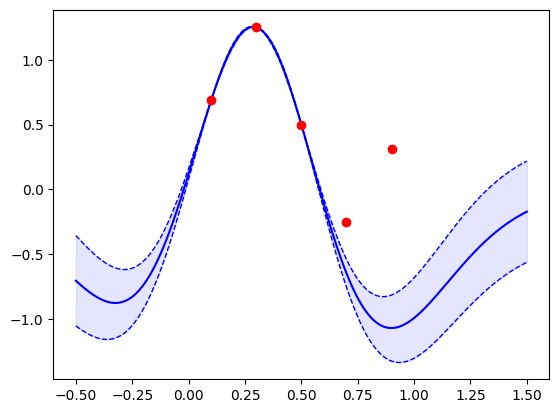

In [19]:
plt.scatter(X, Y_1, zorder=3, c='r')
plot_(X_aux, Y_1_K, var_1, len(X))

In [20]:
Y_1_K = kriging(X_aux, X, Y_1, sigma_1, matern_model(theta_1, nu_1))
Y_2_K = kriging(X_aux, X, Y_2, sigma_2, matern_model(theta_2, nu_2))

In [21]:
Y_coK = co_kriging(X_aux, X, np.concatenate([Y_1, Y_2]), 
               matern_model(theta_1, nu_1), 
               matern_model(theta_2, nu_2), 
               matern_model(theta_12, nu_12),
               rho_12,
               sigma
            )
Y_1_coK = Y_coK[:len(X_aux)]
Y_2_coK = Y_coK[len(X_aux):]

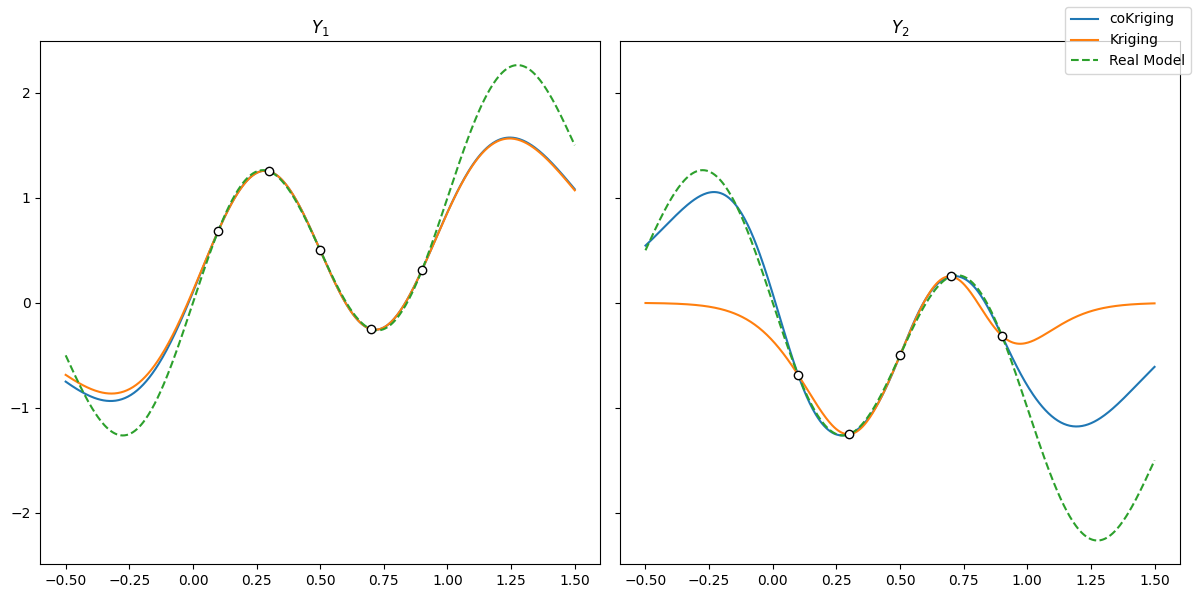

In [22]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6), sharey=True)

ax1.scatter(X, Y_1, edgecolors='k', c='w', zorder=3)
ax1.plot(X_aux, Y_1_coK, label='coKriging')
ax1.plot(X_aux, Y_1_K, label='Kriging')
ax1.plot(X_aux, Y_aux_1, ls='--', label='Real Model')
ax1.set_title(r'$Y_1$')

ax2.scatter(X, Y_2, edgecolors='k', c='w', zorder=3)
ax2.plot(X_aux, Y_2_coK)
ax2.plot(X_aux, Y_2_K)
ax2.plot(X_aux, Y_aux_2, ls='--')
ax2.set_title(r'$Y_2$')

fig.legend()
fig.tight_layout();

Nested CoKriging

In [23]:
sigma = np.block([[sigma_1[A[0]][:,A[0]], sigma_12[A[0]][:,A[0]]],
                  [sigma_12[A[0]][:,A[0]].T, sigma_2[A[0]][:,A[0]]]])

In [24]:
Y_coK = co_kriging(X_aux, X[A[0]], np.concatenate([Y_1[A[0]], Y_2[A[0]]]), 
               matern_model(theta_1, nu_1), 
               matern_model(theta_2, nu_2), 
               matern_model(theta_12, nu_12),
               rho_12,
               np.block([[sigma_1[A[0]][:,A[0]], sigma_12[A[0]][:,A[0]]],
                         [sigma_12[A[0]][:,A[0]].T, sigma_2[A[0]][:,A[0]]]])
            )
Y_1_coK_1 = Y_coK[:len(X_aux)]
Y_2_coK_1 = Y_coK[len(X_aux):]

In [25]:
Y_coK = co_kriging(X_aux, X[A[1]], np.concatenate([Y_1[A[1]], Y_2[A[1]]]), 
               matern_model(theta_1, nu_1), 
               matern_model(theta_2, nu_2), 
               matern_model(theta_12, nu_12),
               rho_12,
               np.block([[sigma_1[A[1]][:,A[1]], sigma_12[A[1]][:,A[1]]],
                         [sigma_12[A[1]][:,A[1]].T, sigma_2[A[1]][:,A[1]]]])
            )
Y_1_coK_2 = Y_coK[:len(X_aux)]
Y_2_coK_2 = Y_coK[len(X_aux):]

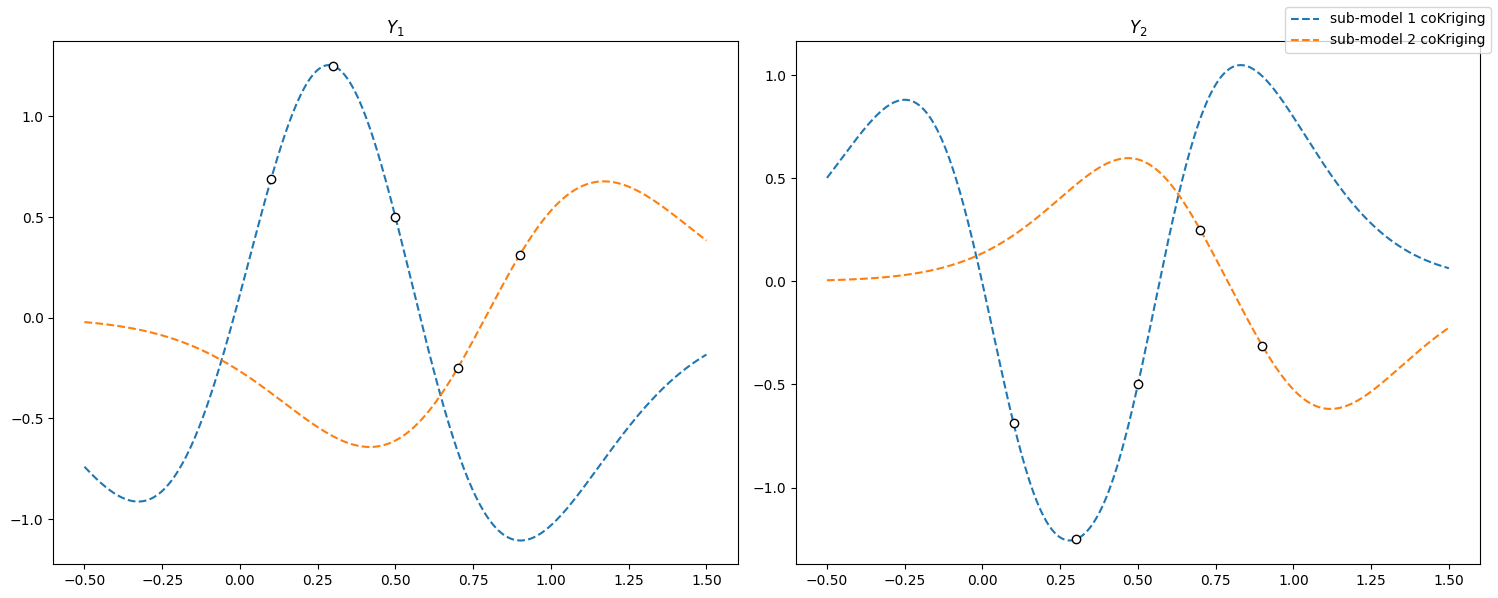

In [26]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

ax1.scatter(X, Y_1, edgecolors='k', c='w', zorder=3)
ax1.plot(X_aux, Y_1_coK_1, ls='--', label='sub-model 1 coKriging')
ax1.plot(X_aux, Y_1_coK_2, ls='--', label='sub-model 2 coKriging')
ax1.set_title(r'$Y_1$')

ax2.scatter(X, Y_2, edgecolors='k', c='w', zorder=3)
ax2.plot(X_aux, Y_2_coK_1, ls='--')
ax2.plot(X_aux, Y_2_coK_2, ls='--')
ax2.set_title(r'$Y_2$')

fig.legend()
fig.tight_layout();

Aggregated

In [27]:
Y_NcoK = np.hstack([nestedCoKriging(X_aux[[i]], X, Y_1, Y_2, A,
                                    matern_model(theta_1, nu_1),
                                    matern_model(theta_2, nu_2),
                                    matern_model(theta_12, nu_12),
                                    rho_12) for i in range(len(X_aux))])

In [28]:
Y_1_NcoK = Y_NcoK[0]
Y_2_NcoK = Y_NcoK[1]

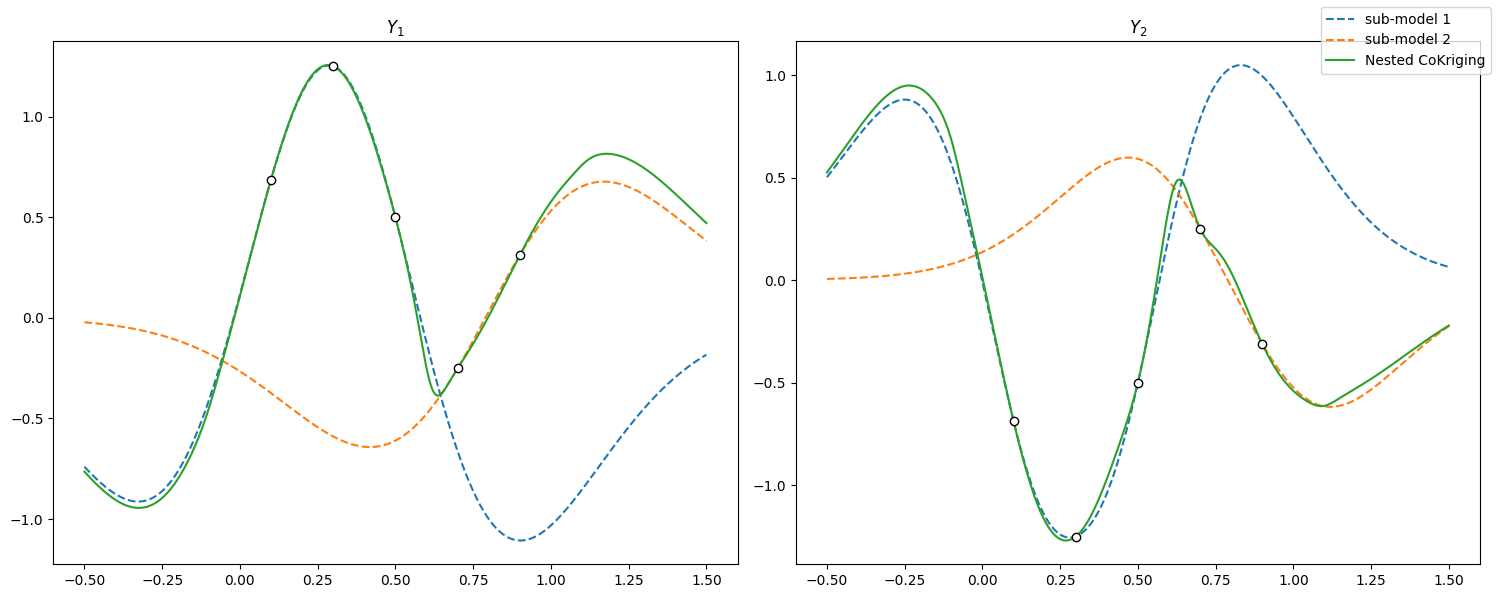

In [29]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

ax1.scatter(X, Y_1, edgecolors='k', c='w', zorder=3)
ax1.plot(X_aux, Y_1_coK_1, ls='--', label='sub-model 1')
ax1.plot(X_aux, Y_1_coK_2, ls='--', label='sub-model 2')
ax1.plot(X_aux, Y_1_NcoK, label='Nested CoKriging')
ax1.set_title(r'$Y_1$')

ax2.scatter(X, Y_2, edgecolors='k', c='w', zorder=3)
ax2.plot(X_aux, Y_2_coK_1, ls='--')
ax2.plot(X_aux, Y_2_coK_2, ls='--')
ax2.plot(X_aux, Y_2_NcoK)
ax2.set_title(r'$Y_2$')

fig.legend()
fig.tight_layout();

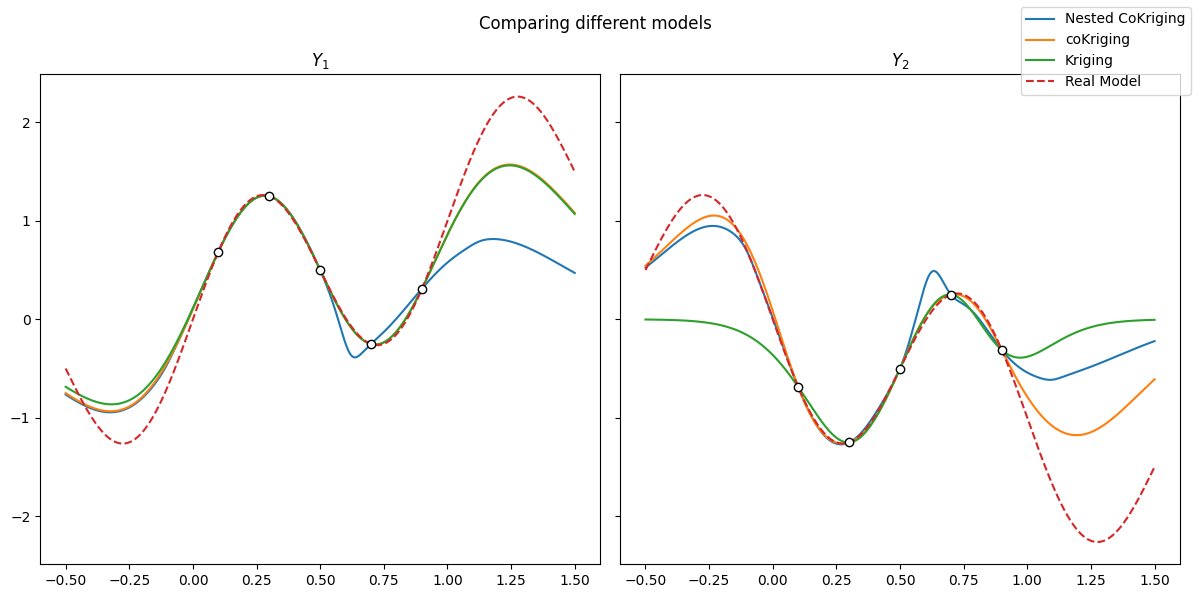

In [30]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6), sharey=True)

ax1.scatter(X, Y_1, edgecolors='k', c='w', zorder=3)
ax1.plot(X_aux, Y_1_NcoK, label='Nested CoKriging')
ax1.plot(X_aux, Y_1_coK, label='coKriging')
ax1.plot(X_aux, Y_1_K, label='Kriging')
ax1.plot(X_aux, Y_aux_1, ls='--', label='Real Model')
ax1.set_title(r'$Y_1$')

ax2.scatter(X, Y_2, edgecolors='k', c='w', zorder=3)
ax2.plot(X_aux, Y_2_NcoK)
ax2.plot(X_aux, Y_2_coK)
ax2.plot(X_aux, Y_2_K)
ax2.plot(X_aux, Y_aux_2, ls='--')
ax2.set_title(r'$Y_2$')

fig.suptitle('Comparing different models')
fig.legend()
fig.tight_layout();

In [31]:
results = []
results.append(('Kriging', root_mean_squared_error(Y_aux_1, Y_1_K), root_mean_squared_error(Y_aux_2, Y_2_K)))
results.append(('coKriging', root_mean_squared_error(Y_aux_1, Y_1_coK), root_mean_squared_error(Y_aux_2, Y_2_coK)))
results.append(('Nested coKriging', root_mean_squared_error(Y_aux_1, Y_1_NcoK), root_mean_squared_error(Y_aux_2, Y_2_NcoK)))

In [32]:
df = pd.DataFrame(data=results, columns=['Método', 'RMSE Y_1', 'RMSE Y_2'])
df

,Método,RMSE Y_1,RMSE Y_2
0,Kriging,0.318586,1.040762
1,coKriging,0.305058,0.479254
2,Nested coKriging,0.631791,0.754123


## Example $d=2$

In [33]:
d = 2
n = 500
sup = 20
X = np.random.uniform(0, sup, (n,d))

In [34]:
# set parameters paper
# https://amath.colorado.edu/faculty/kleiberw/papers/Gneiting2010.pdf
# Figure 1

# sup = 20

nu_1 = 3/2
theta_1 = 1

nu_2 = 1/2
theta_2 = 0.2

nu_12 = 1
theta_12 = 0.6
rho_12 = -0.5

In [35]:
sigma = k(X, X, 
          matern_model(theta_1, nu_1), 
          matern_model(theta_2, nu_2), 
          matern_model(theta_12, nu_12),
          rho_12)

In [36]:
Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, 2*n)

Y_1 = Y[:n]
Y_2 = Y[n:]

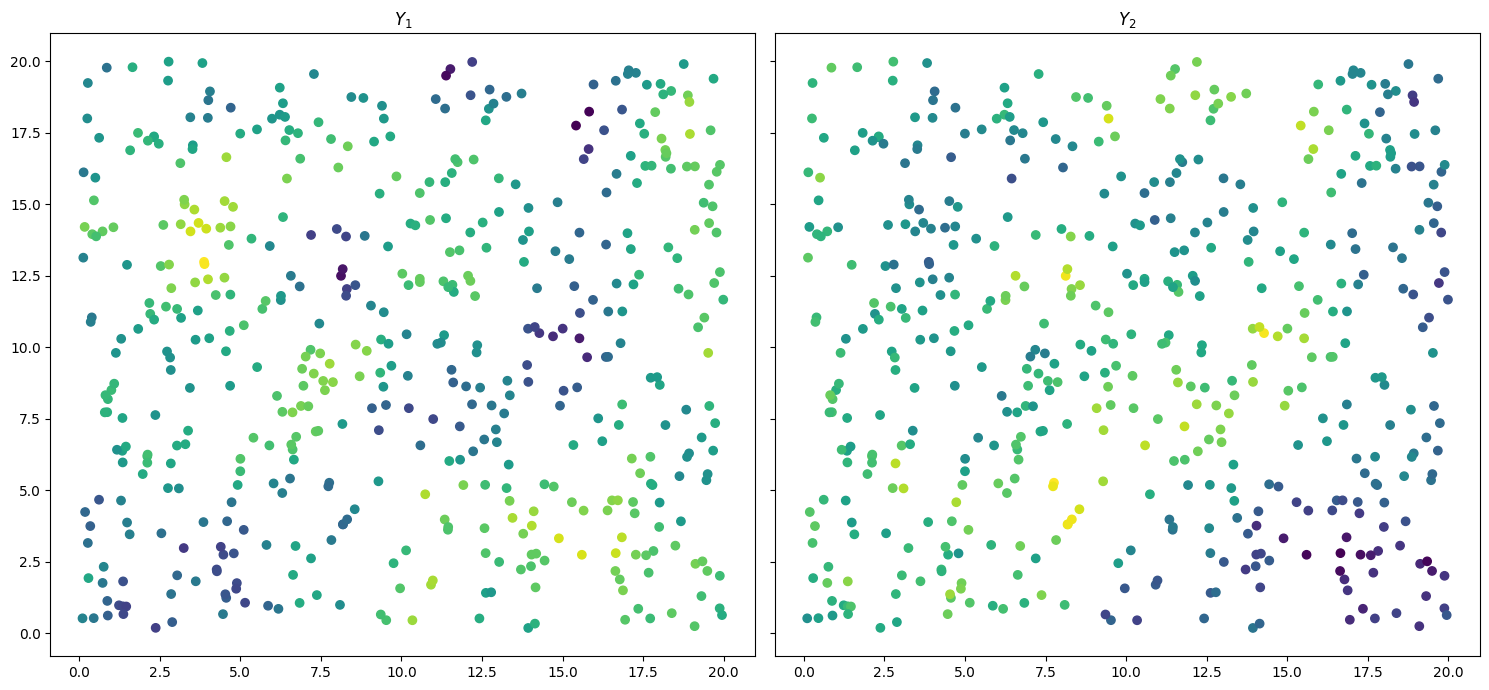

In [37]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,7))

ax1.scatter(X[:,0], X[:,1], c=Y_1)
ax1.set_title(r'$Y_1$')
ax2.scatter(X[:,0], X[:,1], c=Y_2)
ax2.set_title(r'$Y_2$')
fig.tight_layout();

Test set

In [38]:
n_test = 100
X_test = np.random.uniform(0, sup, (n_test,d))
sigma_test = k(X_test, X_test, 
          matern_model(theta_1, nu_1), 
          matern_model(theta_2, nu_2), 
          matern_model(theta_12, nu_12),
          rho_12)
Y_test = np.linalg.cholesky(sigma_test) @ np.random.normal(0, 1, 2*n_test)

Y_1_test = Y_test[:n_test]
Y_2_test = Y_test[n_test:]

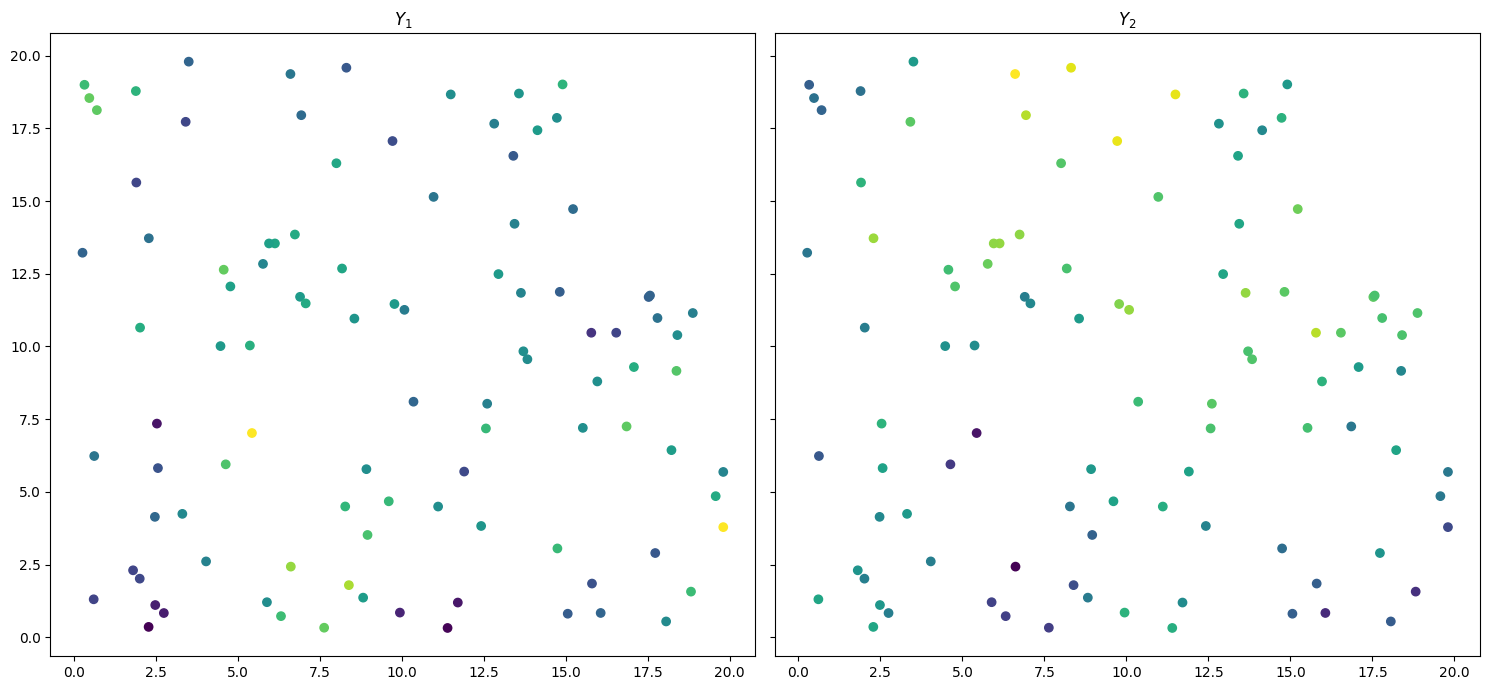

In [39]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,7))

ax1.scatter(X_test[:,0], X_test[:,1], c=Y_1_test)
ax1.set_title(r'$Y_1$')
ax2.scatter(X_test[:,0], X_test[:,1], c=Y_2_test)
ax2.set_title(r'$Y_2$')

fig.tight_layout();

In [40]:
Y_coK = co_kriging(X_test, X, Y, 
                   matern_model(theta_1, nu_1), 
                   matern_model(theta_2, nu_2), 
                   matern_model(theta_12, nu_12),
                   rho_12, sigma)

Y_1_coK = Y_coK[:len(X_test)]
Y_2_coK = Y_coK[len(X_test):]

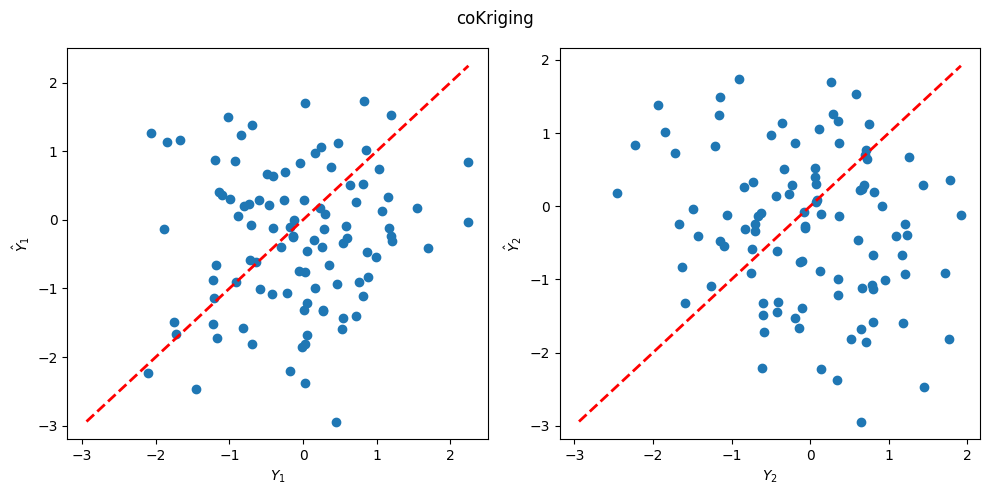

In [41]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
scatterplot(Y_1_test, Y_1_coK, xlabel=r'$Y_1$', ylabel=r'$\hat{Y}_1$')
plt.subplot(1,2,2)
scatterplot(Y_2_test, Y_1_coK, xlabel=r'$Y_2$', ylabel=r'$\hat{Y}_2$')
plt.suptitle(r'coKriging')
plt.tight_layout()

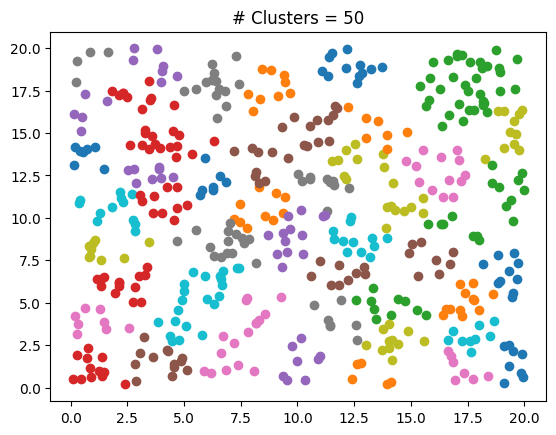

In [42]:
from sklearn.cluster import KMeans

n_clusters = 50
KM = KMeans(n_clusters=n_clusters).fit(X)

A = [[] for _ in range(n_clusters)]
for i, label in enumerate(KM.labels_):
    A[label].append(i)
    
for i in range(len(A)):
    plt.scatter(X[A[i], 0], X[A[i], 1])
plt.title(f'# Clusters = {n_clusters}');

In [43]:
k_X_X = k(X, X, matern_model(theta_1, nu_1),matern_model(theta_2, nu_2),matern_model(theta_12, nu_12),rho_12)

def nestedCoKriging(x, X, Y_1, Y_2, A, cov_1, cov_2, cov_12, rho_12):
    '''
    x : prediction point
    X : the vector of all observation points
    Y_1 : all observations of random field Y_1
    Y_2 : all observations of random field Y_2
    A : list of list with submodels indexes
    cov_ij : covariance function between Y_i and Y_j
    '''
    M = np.zeros((2 * len(A), 1))
    k_M = np.zeros((2 * len(A), 2))
    K_M = np.zeros((2 * len(A), 2 * len(A)))
    k_x_X = k(x, X, cov_1, cov_2, cov_12, rho_12)
    # k_X_X = k(X, X, cov_1, cov_2, cov_12, rho_12)
    
    for i in range(len(A)):
        indexes_i = A[i] + list(np.array(A[i]) + X.shape[0]) 
        k_x_X_i = k_x_X[:, indexes_i]
        k_X_X_i = k_X_X[indexes_i][:, indexes_i]
        
        M[2*i:(2*i+2), :] = (k_x_X_i @ np.linalg.solve(k_X_X_i, np.concatenate([Y_1[A[i]], Y_2[A[i]]]))).reshape((2,1))
        k_M[2*i:(2*i+2), :] = k_x_X_i @ np.linalg.solve(k_X_X_i, k_x_X_i.T)
        K_M[2*i:(2*i+2),2*i:(2*i+2)] = k_M[2*i:(2*i+2), :]
        for j in range(i+1, len(A)):
            indexes_j = A[j] + list(np.array(A[j]) + X.shape[0]) 
            k_x_X_j = k_x_X[:, indexes_j]
            k_X_X_j = k_X_X[indexes_j][:, indexes_j]
            k_X_i_X_j = k_X_X[indexes_i][:, indexes_j]
            
            K_M[2*i:(2*i+2),2*j:(2*j+2)] = np.linalg.solve(k_X_X_i, k_x_X_i.T).T @ k_X_i_X_j @ np.linalg.solve(k_X_X_j, k_x_X_j.T)  
            K_M[2*j:(2*j+2),2*i:(2*i+2)] = K_M[2*i:(2*i+2),2*j:(2*j+2)].T

    return k_M.T @ np.linalg.solve(K_M, M)

In [44]:
Y_NcoK = np.hstack([nestedCoKriging(X_test[[i]], X, Y_1, Y_2, A,
                                    matern_model(theta_1, nu_1),
                                    matern_model(theta_2, nu_2),
                                    matern_model(theta_12, nu_12),
                                    rho_12) for i in range(len(X_test))])

In [45]:
Y_1_NcoK = Y_NcoK[0]
Y_2_NcoK = Y_NcoK[1]

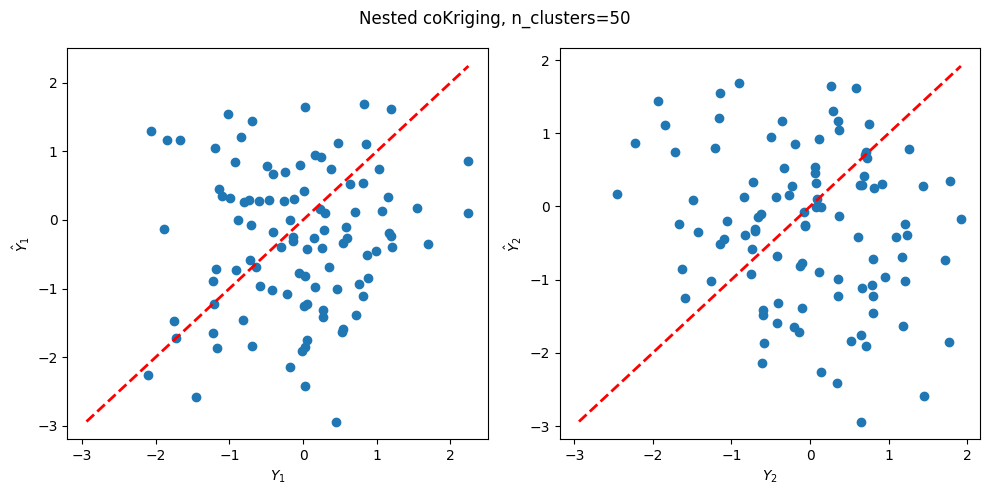

In [46]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
scatterplot(Y_1_test, Y_1_NcoK, xlabel=r'$Y_1$', ylabel=r'$\hat{Y}_1$')
plt.subplot(1,2,2)
scatterplot(Y_2_test, Y_1_NcoK, xlabel=r'$Y_2$', ylabel=r'$\hat{Y}_2$')
plt.suptitle(f'Nested coKriging, {n_clusters=}')
plt.tight_layout()

In [47]:
Y_1_K = kriging(X_test, X, Y_1, sigma[:n,:n], matern_model(theta_1, nu_1))
Y_2_K = kriging(X_test, X, Y_2, sigma[-n:,-n:], matern_model(theta_2, nu_2))

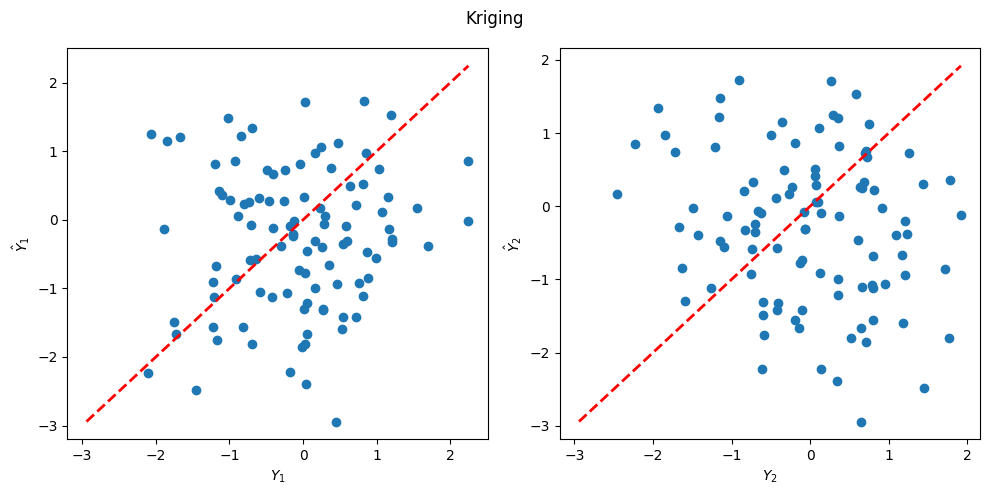

In [48]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
scatterplot(Y_1_test, Y_1_K, xlabel=r'$Y_1$', ylabel=r'$\hat{Y}_1$')
plt.subplot(1,2,2)
scatterplot(Y_2_test, Y_1_K, xlabel=r'$Y_2$', ylabel=r'$\hat{Y}_2$')
plt.suptitle(r'Kriging')
plt.tight_layout()

In [49]:
results = []
results.append(('Kriging', root_mean_squared_error(Y_1_test, Y_1_K), root_mean_squared_error(Y_2_test, Y_2_K)))
results.append(('coKriging', root_mean_squared_error(Y_1_test, Y_1_coK), root_mean_squared_error(Y_2_test, Y_2_coK)))
results.append(('Nested coKriging', root_mean_squared_error(Y_1_test, Y_1_NcoK), root_mean_squared_error(Y_2_test, Y_2_NcoK)))

In [50]:
df = pd.DataFrame(data=results, columns=['Método', 'RMSE Y_1', 'RMSE Y_2'])
df

,Método,RMSE Y_1,RMSE Y_2
0,Kriging,1.326645,1.176400
1,coKriging,1.324175,1.175999
2,Nested coKriging,1.339001,1.176148


## PRUEBA PARA HETEROTOPIC DATA

In [182]:
d = 2

n_1 = 150
n_2 = 1_000

sup = 20
X_1 = np.random.uniform(0, sup, (n_1, d))
X_2 = np.random.uniform(0, sup, (n_2, d))

# Parameters

nu_1 = 3/2
theta_1 = 1

nu_2 = 1/2
theta_2 = 0.2

nu_12 = 1
theta_12 = 0.6
rho_12 = -0.5

In [183]:
def K(X_1, X_2, cov_1, cov_2, cov_12, rho_12):
    return np.block([[cov_matrix(cov_1, X_1, X_1), cov_matrix(cov_12, X_1, X_2, rho_12)], 
                     [cov_matrix(cov_12, X_2, X_1, rho_12), cov_matrix(cov_2, X_2, X_2)]])

In [184]:
sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12)

Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (n_1+n_2))

Y_1 = Y[:n_1]
Y_2 = Y[n_1:]

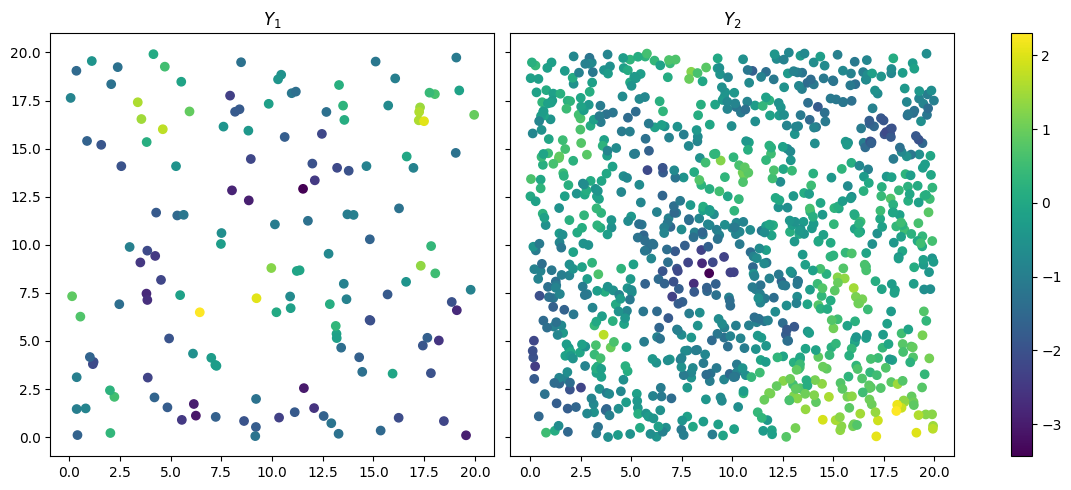

In [185]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 5))

ax1.scatter(X_1[:, 0], X_1[:, 1], c=Y_1)
ax1.set_title(r'$Y_1$')

scatter2 = ax2.scatter(X_2[:, 0], X_2[:, 1], c=Y_2)
ax2.set_title(r'$Y_2$')

fig.tight_layout()

fig.colorbar(scatter2, ax=[ax1, ax2]);

In [186]:
X_1.shape,X_2.shape

((150, 2), (1000, 2))

In [187]:
A = [[list(range(0,50)), list(range(0, 100))], 
     [list(range(50, 70)), list(range(200, 500))],
     [list(range(70, 85)), list(range(500, 700))],
     [list(range(85, 100)), list(range(700, 800))],
     # [list(range(100, 150)), list(range(800, 830))],
     # [list(range(150, 230)), list(range(830, 900))],
     ]

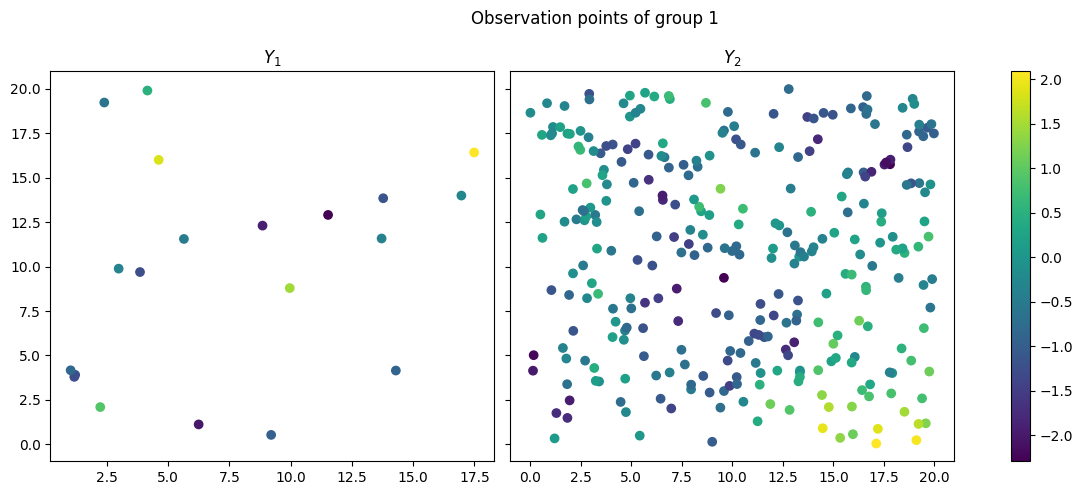

In [188]:
# submodel
i = 1

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 5))

ax1.scatter(X_1[A[i][0], 0], X_1[A[i][0], 1], c=Y_1[A[i][0]])
ax1.set_title(r'$Y_1$')

scatter2 = ax2.scatter(X_2[A[i][1], 0], X_2[A[i][1], 1], c=Y_2[A[i][1]])
ax2.set_title(r'$Y_2$')

fig.suptitle(f'Observation points of group {i}')
fig.tight_layout()

fig.colorbar(scatter2, ax=[ax1, ax2]);


In [189]:
lens_A = [sum(len(subsublist) for subsublist in sublist) for sublist in A]
lens_A

[150, 320, 215, 115]

In [190]:
def k(x, X_1, X_2, cov_1, cov_12, rho_12):
    return np.concatenate([cov_matrix(cov_1, X_1, x), cov_matrix(cov_12, X_2, x, rho_12)])

def nestedCoKriging(x, X_1, X_2, Y, sigma, A, cov_1, cov_12, rho_12):
    '''
    x : prediction point
    X_1 : the vector of all observation points of random field Y_1
    X_2 : the vector of all observation points of random field Y_2
    Y : all observations of random fields Y_1 and Y_2, in that order
    sigma : covariance matrix
    A : list of list with submodels indexes
    # cov_ij : covariance function between Y_i and Y_j
    
    Nos interesa predecir Y_1 con función de covarianza cov_1.
    '''
    lens_A = [sum(len(subsublist) for subsublist in sublist) for sublist in A]
    cumsum_lens_A = np.cumsum(lens_A)
    
    row, ZZZ = 0, np.zeros((sum(lens_A), sum(lens_A)))
    
    for i in range(len(A)):
        column=cumsum_lens_A[i]
        for j in range(i+1, len(A)):
            indexes_i = A[i][0]+list(X_1.shape[0]+np.array(A[i][1]))
            indexes_j = A[j][0]+list(X_1.shape[0]+np.array(A[j][1]))
            ZZZ[row:(row+lens_A[i]), column:(column+lens_A[j])] = sigma[indexes_i, :][:, indexes_j]
            column+=lens_A[j]
        row+=lens_A[i]
    
    ZZZ += ZZZ.T
    
    k_x_Xs = k(x, X_1, X_2, cov_1, cov_12, rho_12)
    
    pivot, C = 0, np.zeros((sum(lens_A), len(A)))
    
    # M = np.zeros((len(A), 1))
    super_Y = np.zeros((sum(lens_A), 1))
    
    for i in range(len(A)):
        indexes = A[i][0]+list(X_1.shape[0]+np.array(A[i][1]))
        ZZZ[pivot:(pivot+lens_A[i]), pivot:(pivot+lens_A[i])] = sigma[indexes, :][:, indexes]
        
        C[pivot:(pivot+lens_A[i]), [i]] = np.linalg.solve(sigma[indexes, :][:, indexes], k_x_Xs[indexes, :])
        
        # M[i] = C[pivot:(pivot+lens_A[i]), [i]].T @ Y[indexes]
        super_Y[pivot:(pivot+lens_A[i]), 0] = Y[indexes]
        
        pivot+=lens_A[i]
        
    # M = C.T @ SUPER_Y
    # cov(M, M) = C.T @ ZZZ @ C
    # cov(M, Y) = diag(C.T @ ZZZ @ C)
    
    K_M = C.T @ ZZZ @ C
    M = C.T @ super_Y
    return np.diag(K_M) @ np.linalg.solve(K_M, M)

IDEA: Crear clase que para la primera vez que predigamos en un sitio 'x' genera la matriz 'ZZZ' y despues la podamos reutilizar si queremos volver a predecir en otro 'x'.

In [192]:
X_1_test = X_1[list(range(100, 150))]

Y_1_test = Y_1[list(range(100, 150))]

In [193]:
Y_1_ncoK = np.array([nestedCoKriging(X_1_test[[i]], X_1, X_2, np.concatenate([Y_1, Y_2]), sigma, A,
                matern_model(theta_1, nu_1), matern_model(theta_12, nu_12), rho_12) for i in range(len(X_1_test))])

0.5618518050279016

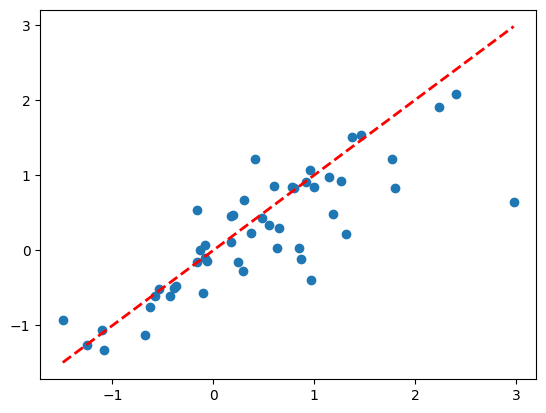

In [194]:
scatterplot(Y_1_test, Y_1_ncoK)
root_mean_squared_error(Y_1_test, Y_1_ncoK)

0.5971183802383843

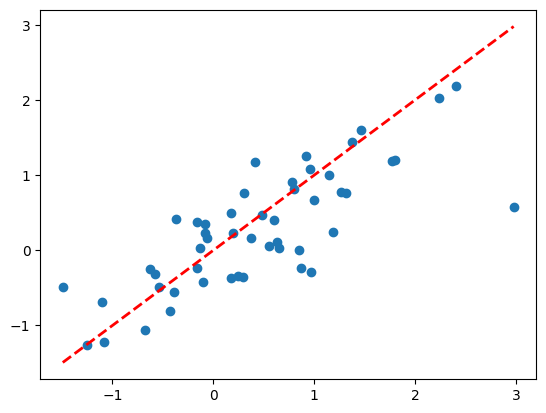

In [195]:
Y_1_K = kriging(X_1_test, X_1[:100], Y_1[:100], sigma[:100, :100], matern_model(theta_1, nu_1))

scatterplot(Y_1_test, Y_1_K)
root_mean_squared_error(Y_1_test, Y_1_K)